In [1]:
# in this script we will calculate the albedo feedback using Karen Shell's CAM3 kernels to validate our own albedo results

# by: Ty Janoski
# edited: 060420

In [27]:
# import statements
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xesmf as xe

In [28]:
# Load in CAM3 abledo kernels
ds_SWAS = xr.open_dataset('/dx07/tylerj/CMIP5_output/shell_kernels/CAM3_albedo_sw_kernel.nc')
lats = ds_SWAS.lat
lons = ds_SWAS.lon

# create a dataset with lat/lons for regridding
ds_out = xr.Dataset({'lat': (['lat'], lats),
                     'lon': (['lon'], lons),
                    }
                   )
ds_SWCS = xr.open_dataset('/dx07/tylerj/CMIP5_output/shell_kernels/CAM3_albedo_sw_clr_kernel.nc')

In [29]:
models = ['ACCESS1-0','ACCESS1-3','CNRM-CM5','IPSL-CM5B-LR', 'GFDL-ESM2G',
         'MIROC-ESM', 'FGOALS-g2','bcc-csm1-1','BNU-ESM','CanESM2','CCSM4',
          'CSIRO-Mk3-6-0','FGOALS-s2','GFDL-CM3','inmcm4',
         'IPSL-CM5A-LR','MIROC5','MPI-ESM-LR','MPI-ESM-P','MRI-CGCM3','NorESM1-M']
for mod in models:
    print(mod)
    # read in last 50 years of piControl
    # rsus = upward SW at surf, rsds = downward SW at surf
    rsds = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/piControl/rsds_Amon_'+mod+'_*.nc',
                              parallel=True,combine='by_coords',use_cftime=True).rsds.isel(time=
                                                                          slice(-600,None))
    if(mod!='CCSM4'):
        rsus = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/piControl/rsus_Amon_'+mod+'_*.nc',
                              parallel=True,combine='by_coords',use_cftime=True).rsus.isel(time=
                                                                          slice(-600,None))
    else:
        rsus = xr.open_dataset('http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/'+
                               '.piControl/.atmos/.mon/.rsus/.CCSM4/.r1i1p1/.rsus/dods',
                               decode_times=False)['rsus'].isel(
            T=slice(-600,None)).rename({'T':'time'})
        rsus['time'] = rsds['time']
    # albedo is up/down SW
    albedo = rsus/(rsds.where(rsds>1e-3))
    
    # make monthly climatology
    clim = albedo.groupby(albedo.time.dt.month).mean(dim='time').compute()
    
    # repeat process for abrupt4xCO2
    
    rsus = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/abrupt4xCO2/rsus_Amon_'+mod+'_*.nc',
                              parallel=True,combine='by_coords',use_cftime=True).rsus.isel(time=
                                                                          slice(None,1800))
    rsds = xr.open_mfdataset('/dx07/tylerj/CMIP5_output/abrupt4xCO2/rsds_Amon_'+mod+'_*.nc',
                              parallel=True,combine='by_coords',use_cftime=True).rsds.isel(time=
                                                                          slice(None,1800))
    albedo = rsus/(rsds.where(rsds>1e-3))
    
    # take difference between abrupt4xCO2 and monthly climatology
    regridder = xe.Regridder(albedo,ds_out,'bilinear',periodic=True,reuse_weights=True)

    diff = regridder((albedo - np.tile(clim,(150,1,1))).compute())
        
    all_sky = (diff * np.tile(ds_SWAS.monkernel,(150,1,1)) * 100).fillna(0)
    clear_sky = (diff * np.tile(ds_SWCS.monkernel,(150,1,1)) * 100).fillna(0)
    
    # save output
    out = xr.merge([all_sky.rename('albedo_SWAS'),clear_sky.rename('albedo_SWCS')])
    out.to_netcdf('/dx07/tylerj/CMIP5_output/CMIP5_feedbacks/'+mod+
                  '_shell_albedo.nc')

ACCESS1-0


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_145x192_64x128_peri.nc
ACCESS1-3


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_145x192_64x128_peri.nc
CNRM-CM5


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_128x256_64x128_peri.nc
IPSL-CM5B-LR


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_96x96_64x128_peri.nc
GFDL-ESM2G


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_90x144_64x128_peri.nc
MIROC-ESM


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_64x128_64x128_peri.nc
FGOALS-g2


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_60x128_64x128_peri.nc
bcc-csm1-1


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_64x128_64x128_peri.nc
BNU-ESM


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_64x128_64x128_peri.nc
CanESM2


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_64x128_64x128_peri.nc
CCSM4


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_192x288_64x128_peri.nc
CSIRO-Mk3-6-0
Create weight file: bilinear_96x192_64x128_peri.nc
FGOALS-s2


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_108x128_64x128_peri.nc
GFDL-CM3


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_90x144_64x128_peri.nc
inmcm4


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_120x180_64x128_peri.nc
IPSL-CM5A-LR


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_96x96_64x128_peri.nc
MIROC5


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Reuse existing file: bilinear_128x256_64x128_peri.nc
MPI-ESM-LR
Reuse existing file: bilinear_96x192_64x128_peri.nc
MPI-ESM-P
Reuse existing file: bilinear_96x192_64x128_peri.nc
MRI-CGCM3


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_160x320_64x128_peri.nc
NorESM1-M


/home/tylerj/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Create weight file: bilinear_96x144_64x128_peri.nc


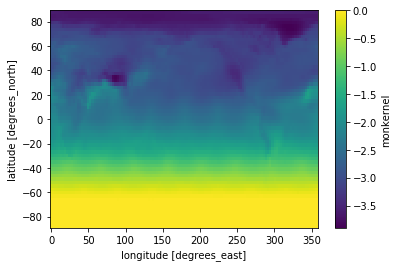

In [19]:
ds_SWCS.monkernel.isel(record=5).plot()

In [17]:
# Load in CAM5 abledo kernels
ds_ker = xr.open_dataset('/dx05/tylerj/d10/Arctic_Research/CMIP5_Arctic_Amplification/\
CAM5_kernels/alb.kernel.nc')

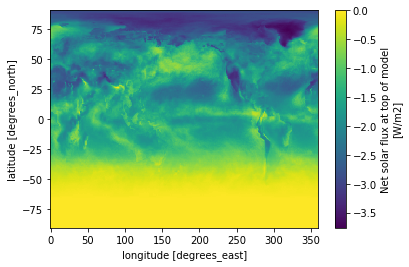

In [21]:
ds_ker.FSNT.isel(time=5).plot()

<xarray.DataArray 'FSNS' (lat: 192, lon: 288)>
array([[-4.14171 , -4.135434, -4.13517 , ..., -4.135646, -4.141788, -4.134989],
       [-4.106882, -4.107452, -4.103479, ..., -4.119666, -4.115105, -4.116061],
       [-4.119119, -4.121717, -4.130625, ..., -4.123753, -4.121651, -4.120535],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    cell_methods:       time: mean
    long_name:          Net solar flux at surface
    units:              W/m2
    Sampling_Sequence:  rad_lwsw